In [1]:
import sys
import SimpleITK as sitk
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline 
import numpy as np
import os
import fnmatch
import shutil
from ipywidgets import interact, fixed
import pandas as pd
from pathlib import Path
from skimage import exposure
#function for showing volume images
def myshow(image_arr,slice_n):
    plt.imshow(image_arr[slice_n,:,:],cmap='gray')
    plt.show()

In [2]:
#reading metadata csv, whcih we do not need for the project, as we are doing only segmentation part

data = pd.read_csv('/mnt/e//Image Processing/Brats Project/new/survival_data.csv')
data.head(5)

BraTS18ID     Age  Survival ResectionStatus
0  Brats18_TCIA08_167_1  74.907       153             NaN
1  Brats18_TCIA08_242_1  66.479       147             NaN
2  Brats18_TCIA08_319_1  64.860       254             NaN
3  Brats18_TCIA08_469_1  63.899       519             NaN
4  Brats18_TCIA08_218_1  57.345       346             NaN

In [3]:
#creating lists with images of different modalities

common_list = []
t2_list = []
t1_list = []
t1ce_list = []
flair_list = []
seg_list = []
for (dirpath, dirnames, filenames) in os.walk('/mnt/e//Image Processing/Brats Project/new/'):
    for filename in filenames: 
        if filename.endswith('.csv')==False and 'seg' not in filename.split('.')[0]:
            common_list.append(os.path.join(dirpath,filename))
            if 't2' in filename.split('.')[0]: 
                t2_list.append(os.path.join(dirpath,filename))
            if 't1' in filename.split('.')[0] and 't1ce' not in filename.split('.')[0]:
                t1_list.append(os.path.join(dirpath,filename))
            if 't1ce' in filename.split('.')[0]:
                t1ce_list.append(os.path.join(dirpath,filename))
            if 'flair' in filename.split('.')[0]:
                flair_list.append(os.path.join(dirpath,filename))
        if 'seg' in filename.split('.')[0]:
            seg_list.append(os.path.join(dirpath,filename))

In [4]:
#All of Modalities` paths into one dataframe for further processing

paths_data=pd.DataFrame(np.column_stack([t1_list,t1ce_list,t2_list,flair_list,seg_list]),
                       columns=['t1_p','t1ce_p','t2_p','flair_p','seg_p'])

pd.set_option('display.max_colwidth', -1)
paths_data.loc[250,:]

t1_p       /mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_393_1/Brats18_TCIA10_393_1_t1.nii.gz   
t1ce_p     /mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_393_1/Brats18_TCIA10_393_1_t1ce.nii.gz 
t2_p       /mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_393_1/Brats18_TCIA10_393_1_t2.nii.gz   
flair_p    /mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_393_1/Brats18_TCIA10_393_1_flair.nii.gz
seg_p      /mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_393_1/Brats18_TCIA10_393_1_seg.nii.gz  
Name: 250, dtype: object

In [5]:
#EDA functions
def plot_spacing(l):
    ''' 

    this function helps to plot spacing histograms 
    
    l = list with files` paths 


    '''    
    temp_list=[]
    
    for image in l:
        image_read=sitk.ReadImage(image)
        value=list(image_read.GetSpacing())
        value = [round(i,2) for i in value ]
        temp_list.append((str(value)).strip('[]'))

    
    temp_df=pd.DataFrame(temp_list)
    
    
    plt.figure(figsize=(12,7))
    plt.suptitle('Pixel Spacing (x,y,z)',fontsize=20)
    ax=temp_df[0].value_counts().plot(kind='bar')
    ax.set_xlabel('pixel spacing (x,y,z) in mm',fontsize='large')
    ax.set_ylabel('patients count',fontsize='large')
    plt.show()



def plot_size(l):
    '''
    this function helps to plot size histograms 
    
    l = list with files` paths
    '''
    temp_list=[]
    
    for image in l:
        image_read=sitk.ReadImage(image)
        value=list(image_read.GetSize())
        value = [round(i,2) for i in value ]
        temp_list.append((str(value)).strip('[]'))

    
    temp_df=pd.DataFrame(temp_list)
    
    
    plt.figure(figsize=(12,7))
    plt.suptitle('Size',fontsize=20)
    ax=temp_df[0].value_counts().plot(kind='bar')
    ax.set_xlabel('Size ',fontsize='large')
    ax.set_ylabel('patients count',fontsize='large')
    plt.show()

In [6]:
common_list

['/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii.gz',
 '/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1.nii.gz',
 '/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1ce.nii.gz',
 '/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t2.nii.gz',
 '/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_11_1/Brats18_2013_11_1_flair.nii.gz',
 '/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_11_1/Brats18_2013_11_1_t1.nii.gz',
 '/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_11_1/Brats18_2013_11_1_t1ce.nii.gz',
 '/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_11_1/Brats18_2013_11_1_t2.nii.gz',
 '/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_12_1/Brats18_2013_12_1_flair.nii.gz',
 '/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_12_1/Brats18_2013_12_1_t1.nii.gz',
 '/mnt/e//Image P

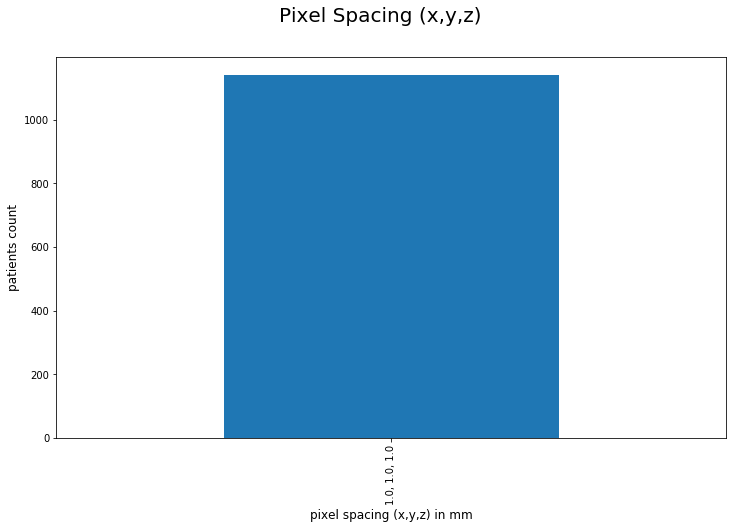

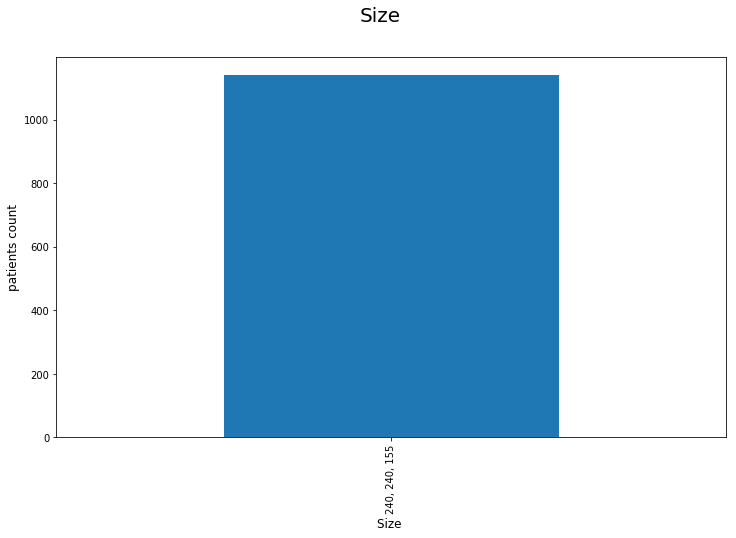

In [7]:
plot_spacing(common_list)
plot_size(common_list)

#We have perfect pixel spacing and size. Hence, do not need resampling now

In [8]:
#For further processing we should plot Intensity Ranges
#Necessary because if it is differ we should normilize them

def plot_intensities(l,how='counts'):
    #plot intensity ranges 
    
    #l= path for the images
    
    #'counts' = plots all intensity ranges among all images
    #'min/max' = plots min and max values among all images
    
    temp_list_counts = []
    min_max_list = []
    
    def getMinMax(img):
        #Function that takes minimum and maximum value from one image
        mm = sitk.MinimumMaximumImageFilter()
        mm.Execute(img)
        return (mm.GetMinimum(), mm.GetMaximum())
    
    for image in l:
        image_read=sitk.ReadImage(image)
        value = getMinMax(image_read)
        temp_list_counts.append(str(value).strip('()'))
        for i in value:
            min_max_list.append(i)
    temp_df_counts=pd.DataFrame(temp_list_counts)
    
    if how=='counts':
    
        plt.figure(figsize=(12,7))
        plt.suptitle('Intensity Range', fontsize=20)
        ax=temp_df_counts[0].value_counts().plot(kind='bar')
        ax.set_xlabel('Intensities', fontsize='large')
        ax.set_ylabel('Counts',fontsize='large')
        plt.show()
    
    if how=='min/max':
        print('the minimum intesity value is:\t{}\nthe maximum intensity value is:\t{}'.format(min(min_max_list), max(min_max_list)))
    


In [9]:
#Checking Intensities before normalization 

#Intensity Ranges among all images

plot_intensities(common_list, how='min/max')

the minimum intesity value is:	0.0
the maximum intensity value is:	32767.0


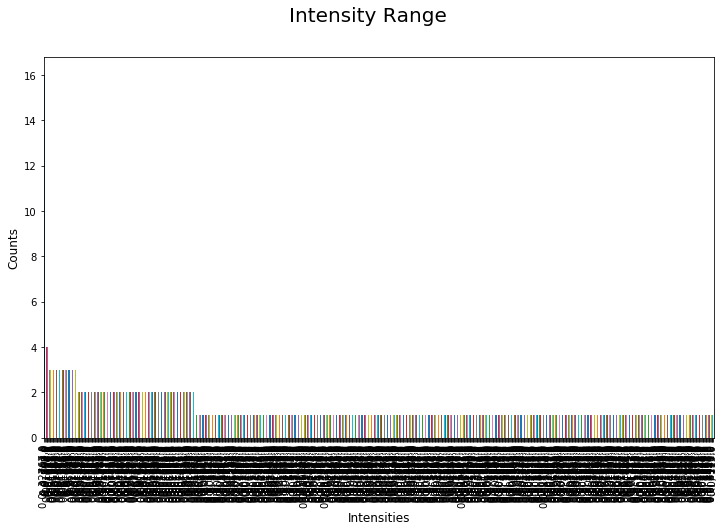

In [10]:
#Plotting Intensities Ranges
#Very heterogenous results

plot_intensities(common_list)

# Normalization to [-127,127] scale range 

In [ ]:
#Rescaling by Linear Function 

#another way to normalize images (slower), but more precise

OUT_DIR = './all_modalities/'


def rescale_to(l, newmin_value = -127.0, newmax_value = 127.0, out_dir = OUT_DIR):
    
    
    
    #defining function which is going to rescale values to predefined values` range
    def to_norm(im_arr, newmin = newmin_value, newmax = newmax_value):
        norm_arr = (im_arr - im_arr.min()) * ((newmax - newmin) / (im_arr.max() - im_arr.min())) + newmin
        return norm_arr
    
    
    for i in l: 
        image = sitk.ReadImage(i)
        im_arr = sitk.GetArrayFromImage(image)
        normed_arr = to_norm(im_arr)
        normed_im = sitk.GetImageFromArray(normed_arr) #Getting image from normed array 
        
        #write normed image to output_dir
        name =  i.split('\\')[-1]
        sitk.WriteImage(normed_im, os.path.join(out_dir, name))
        
        print('{} rescaled and written to {}'.format(name, out_dir))

        
        
        
rescale_to(common_list)

In [11]:
#Rescaling by RescaleIntensityImageFilter() 

out_dir = './all_modalities/'

def norm_all(l):
    #set intensity scale to the range of [-127,127]
    imadjust = sitk.RescaleIntensityImageFilter()
    imadjust.SetOutputMinimum( -127 )
    imadjust.SetOutputMaximum( 127 )    
    for image in l: 
        im=sitk.ReadImage(image)
        print(image, '\tread')
        norm_im=imadjust.Execute( im )
        print(image, '\tnormalized')
        name =  image.split('\\')[-1]
        sitk.WriteImage(norm_im, os.path.join(out_dir, name))
        
        print('{} normalized and written to {}'.format(name, out_dir))
        
            
        
norm_all(common_list) #applying         

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1ce.nii.gz normal

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_18_1/Brats18_2013_18_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_18_1/Brats18_2013_18_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_18_1/Brats18_2013_18_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_18_1/Brats18_2013_18_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_18_1/Brats18_2013_18_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_18_1/Brats18_2013_18_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_18_1/Brats18_2013_18_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_18_1/Brats18_2013_18_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_18_1/Brats18_

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_25_1/Brats18_2013_25_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_25_1/Brats18_2013_25_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_25_1/Brats18_2013_25_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_25_1/Brats18_2013_25_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_25_1/Brats18_2013_25_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_25_1/Brats18_2013_25_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_25_1/Brats18_2013_25_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_25_1/Brats18_2013_25_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_25_1/Brats18_

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_5_1/Brats18_2013_5_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_5_1/Brats18_2013_5_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_5_1/Brats18_2013_5_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_5_1/Brats18_2013_5_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_5_1/Brats18_2013_5_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_5_1/Brats18_2013_5_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_5_1/Brats18_2013_5_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_5_1/Brats18_2013_5_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_2013_5_1/Brats18_2013_5_1_t2.nii.g

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ABB_1/Brats18_CBICA_ABB_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ABB_1/Brats18_CBICA_ABB_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ABB_1/Brats18_CBICA_ABB_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ABB_1/Brats18_CBICA_ABB_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ABB_1/Brats18_CBICA_ABB_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ABB_1/Brats18_CBICA_ABB_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ABB_1/Brats18_CBICA_ABB_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ABB_1/Brats18_CBICA_ABB_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/ne

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ABY_1/Brats18_CBICA_ABY_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ALN_1/Brats18_CBICA_ALN_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ALN_1/Brats18_CBICA_ALN_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ALN_1/Brats18_CBICA_ALN_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ALN_1/Brats18_CBICA_ALN_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ALN_1/Brats18_CBICA_ALN_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ALN_1/Brats18_CBICA_ALN_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ALN_1/Brats18_CBICA_ALN_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ANG_1/Brats18_CBICA_ANG_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ANG_1/Brats18_CBICA_ANG_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ANG_1/Brats18_CBICA_ANG_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ANG_1/Brats18_CBICA_ANG_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ANI_1/Brats18_CBICA_ANI_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ANI_1/Brats18_CBICA_ANI_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ANI_1/Brats18_CBICA_ANI_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ANI_1/Brats18_CBICA_ANI_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AOO_1/Brats18_CBICA_AOO_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AOO_1/Brats18_CBICA_AOO_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AOO_1/Brats18_CBICA_AOO_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AOO_1/Brats18_CBICA_AOO_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AOO_1/Brats18_CBICA_AOO_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AOO_1/Brats18_CBICA_AOO_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AOO_1/Brats18_CBICA_AOO_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AOP_1/Brats18_CBICA_AOP_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/ne

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQA_1/Brats18_CBICA_AQA_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQA_1/Brats18_CBICA_AQA_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQA_1/Brats18_CBICA_AQA_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQA_1/Brats18_CBICA_AQA_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQA_1/Brats18_CBICA_AQA_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQA_1/Brats18_CBICA_AQA_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQA_1/Brats18_CBICA_AQA_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQA_1/Brats18_CBICA_AQA_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/ne

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQO_1/Brats18_CBICA_AQO_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQP_1/Brats18_CBICA_AQP_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQP_1/Brats18_CBICA_AQP_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQP_1/Brats18_CBICA_AQP_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQP_1/Brats18_CBICA_AQP_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQP_1/Brats18_CBICA_AQP_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQP_1/Brats18_CBICA_AQP_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQP_1/Brats18_CBICA_AQP_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQV_1/Brats18_CBICA_AQV_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQV_1/Brats18_CBICA_AQV_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQV_1/Brats18_CBICA_AQV_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQV_1/Brats18_CBICA_AQV_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQY_1/Brats18_CBICA_AQY_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQY_1/Brats18_CBICA_AQY_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQY_1/Brats18_CBICA_AQY_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AQY_1/Brats18_CBICA_AQY_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASA_1/Brats18_CBICA_ASA_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASA_1/Brats18_CBICA_ASA_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASA_1/Brats18_CBICA_ASA_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASA_1/Brats18_CBICA_ASA_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASA_1/Brats18_CBICA_ASA_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASA_1/Brats18_CBICA_ASA_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASA_1/Brats18_CBICA_ASA_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASE_1/Brats18_CBICA_ASE_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/ne

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASO_1/Brats18_CBICA_ASO_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASO_1/Brats18_CBICA_ASO_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASO_1/Brats18_CBICA_ASO_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASO_1/Brats18_CBICA_ASO_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASO_1/Brats18_CBICA_ASO_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASO_1/Brats18_CBICA_ASO_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASO_1/Brats18_CBICA_ASO_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ASO_1/Brats18_CBICA_ASO_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/ne

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ATB_1/Brats18_CBICA_ATB_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AUN_1/Brats18_CBICA_AUN_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AUN_1/Brats18_CBICA_AUN_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AUN_1/Brats18_CBICA_AUN_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AUN_1/Brats18_CBICA_AUN_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AUQ_1/Brats18_CBICA_AUQ_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AUQ_1/Brats18_CBICA_AUQ_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AUQ_1/Brats18_CBICA_AUQ_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AUQ_1/Brats18_CBICA_AUQ_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AWG_1/Brats18_CBICA_AWG_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AWG_1/Brats18_CBICA_AWG_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AWG_1/Brats18_CBICA_AWG_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AWG_1/Brats18_CBICA_AWG_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AWG_1/Brats18_CBICA_AWG_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AWG_1/Brats18_CBICA_AWG_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AWG_1/Brats18_CBICA_AWG_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AWH_1/Brats18_CBICA_AWH_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/ne

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AXN_1/Brats18_CBICA_AXN_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AXN_1/Brats18_CBICA_AXN_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AXN_1/Brats18_CBICA_AXN_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AXN_1/Brats18_CBICA_AXN_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AXN_1/Brats18_CBICA_AXN_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AXN_1/Brats18_CBICA_AXN_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AXN_1/Brats18_CBICA_AXN_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AXN_1/Brats18_CBICA_AXN_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/ne

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AYI_1/Brats18_CBICA_AYI_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AYU_1/Brats18_CBICA_AYU_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AYU_1/Brats18_CBICA_AYU_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AYU_1/Brats18_CBICA_AYU_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AYU_1/Brats18_CBICA_AYU_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AYU_1/Brats18_CBICA_AYU_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AYU_1/Brats18_CBICA_AYU_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_AYU_1/Brats18_CBICA_AYU_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_BFP_1/Brats18_CBICA_BFP_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_BFP_1/Brats18_CBICA_BFP_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_BFP_1/Brats18_CBICA_BFP_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_BFP_1/Brats18_CBICA_BFP_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_BHB_1/Brats18_CBICA_BHB_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_BHB_1/Brats18_CBICA_BHB_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_BHB_1/Brats18_CBICA_BHB_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_CBICA_BHB_1/Brats18_CBICA_BHB_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_150_1/Brats18_TCIA01_150_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_150_1/Brats18_TCIA01_150_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_150_1/Brats18_TCIA01_150_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_150_1/Brats18_TCIA01_150_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_150_1/Brats18_TCIA01_150_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_150_1/Brats18_TCIA01_150_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_150_1/Brats18_TCIA01_150_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_180_1/Brats18_TCIA01_180_1_flair.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_221_1/Brats18_TCIA01_221_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_221_1/Brats18_TCIA01_221_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_221_1/Brats18_TCIA01_221_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_221_1/Brats18_TCIA01_221_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_221_1/Brats18_TCIA01_221_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_221_1/Brats18_TCIA01_221_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_221_1/Brats18_TCIA01_221_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_221_1/Brats18_TCIA01_221_1_t2.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_390_1/Brats18_TCIA01_390_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_401_1/Brats18_TCIA01_401_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_401_1/Brats18_TCIA01_401_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_401_1/Brats18_TCIA01_401_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_401_1/Brats18_TCIA01_401_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_401_1/Brats18_TCIA01_401_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_401_1/Brats18_TCIA01_401_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_401_1/Brats18_TCIA01_401_1_t1ce.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_448_1/Brats18_TCIA01_448_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_448_1/Brats18_TCIA01_448_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_448_1/Brats18_TCIA01_448_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_448_1/Brats18_TCIA01_448_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_t1.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_151_1/Brats18_TCIA02_151_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_151_1/Brats18_TCIA02_151_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_151_1/Brats18_TCIA02_151_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_151_1/Brats18_TCIA02_151_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_151_1/Brats18_TCIA02_151_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_151_1/Brats18_TCIA02_151_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_151_1/Brats18_TCIA02_151_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_168_1/Brats18_TCIA02_168_1_flair.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_222_1/Brats18_TCIA02_222_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_222_1/Brats18_TCIA02_222_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_222_1/Brats18_TCIA02_222_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_222_1/Brats18_TCIA02_222_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_222_1/Brats18_TCIA02_222_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_222_1/Brats18_TCIA02_222_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_222_1/Brats18_TCIA02_222_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_222_1/Brats18_TCIA02_222_1_t2.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_300_1/Brats18_TCIA02_300_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_309_1/Brats18_TCIA02_309_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_309_1/Brats18_TCIA02_309_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_309_1/Brats18_TCIA02_309_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_309_1/Brats18_TCIA02_309_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_309_1/Brats18_TCIA02_309_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_309_1/Brats18_TCIA02_309_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_309_1/Brats18_TCIA02_309_1_t1ce.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_368_1/Brats18_TCIA02_368_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_368_1/Brats18_TCIA02_368_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_368_1/Brats18_TCIA02_368_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_368_1/Brats18_TCIA02_368_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_370_1/Brats18_TCIA02_370_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_370_1/Brats18_TCIA02_370_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_370_1/Brats18_TCIA02_370_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_370_1/Brats18_TCIA02_370_1_t1.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_455_1/Brats18_TCIA02_455_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_455_1/Brats18_TCIA02_455_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_455_1/Brats18_TCIA02_455_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_455_1/Brats18_TCIA02_455_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_455_1/Brats18_TCIA02_455_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_455_1/Brats18_TCIA02_455_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_455_1/Brats18_TCIA02_455_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_471_1/Brats18_TCIA02_471_1_flair.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_607_1/Brats18_TCIA02_607_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_607_1/Brats18_TCIA02_607_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_607_1/Brats18_TCIA02_607_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_607_1/Brats18_TCIA02_607_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_607_1/Brats18_TCIA02_607_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_607_1/Brats18_TCIA02_607_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_607_1/Brats18_TCIA02_607_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA02_607_1/Brats18_TCIA02_607_1_t2.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_199_1/Brats18_TCIA03_199_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_257_1/Brats18_TCIA03_257_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_257_1/Brats18_TCIA03_257_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_257_1/Brats18_TCIA03_257_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_257_1/Brats18_TCIA03_257_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_257_1/Brats18_TCIA03_257_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_257_1/Brats18_TCIA03_257_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_257_1/Brats18_TCIA03_257_1_t1ce.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_419_1/Brats18_TCIA03_419_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_419_1/Brats18_TCIA03_419_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_419_1/Brats18_TCIA03_419_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_419_1/Brats18_TCIA03_419_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_474_1/Brats18_TCIA03_474_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_474_1/Brats18_TCIA03_474_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_474_1/Brats18_TCIA03_474_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA03_474_1/Brats18_TCIA03_474_1_t1.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA04_328_1/Brats18_TCIA04_328_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA04_328_1/Brats18_TCIA04_328_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA04_328_1/Brats18_TCIA04_328_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA04_328_1/Brats18_TCIA04_328_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA04_328_1/Brats18_TCIA04_328_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA04_328_1/Brats18_TCIA04_328_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA04_328_1/Brats18_TCIA04_328_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA04_343_1/Brats18_TCIA04_343_1_flair.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA05_396_1/Brats18_TCIA05_396_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA05_396_1/Brats18_TCIA05_396_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA05_396_1/Brats18_TCIA05_396_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA05_396_1/Brats18_TCIA05_396_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA05_396_1/Brats18_TCIA05_396_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA05_396_1/Brats18_TCIA05_396_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA05_396_1/Brats18_TCIA05_396_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA05_396_1/Brats18_TCIA05_396_1_t2.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA06_211_1/Brats18_TCIA06_211_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA06_247_1/Brats18_TCIA06_247_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA06_247_1/Brats18_TCIA06_247_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA06_247_1/Brats18_TCIA06_247_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA06_247_1/Brats18_TCIA06_247_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA06_247_1/Brats18_TCIA06_247_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA06_247_1/Brats18_TCIA06_247_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA06_247_1/Brats18_TCIA06_247_1_t1ce.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_105_1/Brats18_TCIA08_105_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_105_1/Brats18_TCIA08_105_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_105_1/Brats18_TCIA08_105_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_105_1/Brats18_TCIA08_105_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_113_1/Brats18_TCIA08_113_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_113_1/Brats18_TCIA08_113_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_113_1/Brats18_TCIA08_113_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_113_1/Brats18_TCIA08_113_1_t1.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_234_1/Brats18_TCIA08_234_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_234_1/Brats18_TCIA08_234_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_234_1/Brats18_TCIA08_234_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_234_1/Brats18_TCIA08_234_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_234_1/Brats18_TCIA08_234_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_234_1/Brats18_TCIA08_234_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_234_1/Brats18_TCIA08_234_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_242_1/Brats18_TCIA08_242_1_flair.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_436_1/Brats18_TCIA08_436_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_436_1/Brats18_TCIA08_436_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_436_1/Brats18_TCIA08_436_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_436_1/Brats18_TCIA08_436_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_436_1/Brats18_TCIA08_436_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_436_1/Brats18_TCIA08_436_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_436_1/Brats18_TCIA08_436_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/HGG/Brats18_TCIA08_436_1/Brats18_TCIA08_436_1_t2.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_2013_24_1/Brats18_2013_24_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_2013_24_1/Brats18_2013_24_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_2013_24_1/Brats18_2013_24_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_2013_24_1/Brats18_2013_24_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_2013_24_1/Brats18_2013_24_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_2013_24_1/Brats18_2013_24_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_2013_24_1/Brats18_2013_24_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_2013_24_1/Brats18_2013_24_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_2013_24_1/Brats18_

/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_141_1/Brats18_TCIA09_141_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_141_1/Brats18_TCIA09_141_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_141_1/Brats18_TCIA09_141_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_141_1/Brats18_TCIA09_141_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_141_1/Brats18_TCIA09_141_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_141_1/Brats18_TCIA09_141_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_141_1/Brats18_TCIA09_141_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_141_1/Brats18_TCIA09_141_1_t2.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_402_1/Brats18_TCIA09_402_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_428_1/Brats18_TCIA09_428_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_428_1/Brats18_TCIA09_428_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_428_1/Brats18_TCIA09_428_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_428_1/Brats18_TCIA09_428_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_428_1/Brats18_TCIA09_428_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_428_1/Brats18_TCIA09_428_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA09_428_1/Brats18_TCIA09_428_1_t1ce.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_103_1/Brats18_TCIA10_103_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_103_1/Brats18_TCIA10_103_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_103_1/Brats18_TCIA10_103_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_103_1/Brats18_TCIA10_103_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_109_1/Brats18_TCIA10_109_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_109_1/Brats18_TCIA10_109_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_109_1/Brats18_TCIA10_109_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_109_1/Brats18_TCIA10_109_1_t1.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_241_1/Brats18_TCIA10_241_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_241_1/Brats18_TCIA10_241_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_241_1/Brats18_TCIA10_241_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_241_1/Brats18_TCIA10_241_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_241_1/Brats18_TCIA10_241_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_241_1/Brats18_TCIA10_241_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_241_1/Brats18_TCIA10_241_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_261_1/Brats18_TCIA10_261_1_flair.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_307_1/Brats18_TCIA10_307_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_307_1/Brats18_TCIA10_307_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_307_1/Brats18_TCIA10_307_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_307_1/Brats18_TCIA10_307_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_307_1/Brats18_TCIA10_307_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_307_1/Brats18_TCIA10_307_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_307_1/Brats18_TCIA10_307_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_307_1/Brats18_TCIA10_307_1_t2.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_351_1/Brats18_TCIA10_351_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_387_1/Brats18_TCIA10_387_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_387_1/Brats18_TCIA10_387_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_387_1/Brats18_TCIA10_387_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_387_1/Brats18_TCIA10_387_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_387_1/Brats18_TCIA10_387_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_387_1/Brats18_TCIA10_387_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_387_1/Brats18_TCIA10_387_1_t1ce.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_420_1/Brats18_TCIA10_420_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_420_1/Brats18_TCIA10_420_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_420_1/Brats18_TCIA10_420_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_420_1/Brats18_TCIA10_420_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_442_1/Brats18_TCIA10_442_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_442_1/Brats18_TCIA10_442_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_442_1/Brats18_TCIA10_442_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_442_1/Brats18_TCIA10_442_1_t1.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_629_1/Brats18_TCIA10_629_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_629_1/Brats18_TCIA10_629_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_629_1/Brats18_TCIA10_629_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_629_1/Brats18_TCIA10_629_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_629_1/Brats18_TCIA10_629_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_629_1/Brats18_TCIA10_629_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_629_1/Brats18_TCIA10_629_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA10_632_1/Brats18_TCIA10_632_1_flair.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA12_101_1/Brats18_TCIA12_101_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA12_101_1/Brats18_TCIA12_101_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA12_101_1/Brats18_TCIA12_101_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA12_101_1/Brats18_TCIA12_101_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA12_101_1/Brats18_TCIA12_101_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA12_101_1/Brats18_TCIA12_101_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA12_101_1/Brats18_TCIA12_101_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA12_101_1/Brats18_TCIA12_101_1_t2.nii.gz 	read
/mnt/e//Image Processing/

/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA12_480_1/Brats18_TCIA12_480_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_615_1/Brats18_TCIA13_615_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_615_1/Brats18_TCIA13_615_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_615_1/Brats18_TCIA13_615_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_615_1/Brats18_TCIA13_615_1_t1.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_615_1/Brats18_TCIA13_615_1_t1.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_615_1/Brats18_TCIA13_615_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_615_1/Brats18_TCIA13_615_1_t1ce.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_630_1/Brats18_TCIA13_630_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_630_1/Brats18_TCIA13_630_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_630_1/Brats18_TCIA13_630_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_630_1/Brats18_TCIA13_630_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_633_1/Brats18_TCIA13_633_1_flair.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_633_1/Brats18_TCIA13_633_1_flair.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_633_1/Brats18_TCIA13_633_1_flair.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_633_1/Brats18_TCIA13_633_1_t1.nii.gz 	read
/mnt/e//Image Processin

/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_653_1/Brats18_TCIA13_653_1_t1.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_653_1/Brats18_TCIA13_653_1_t1ce.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_653_1/Brats18_TCIA13_653_1_t1ce.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_653_1/Brats18_TCIA13_653_1_t1ce.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_653_1/Brats18_TCIA13_653_1_t2.nii.gz 	read
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_653_1/Brats18_TCIA13_653_1_t2.nii.gz 	normalized
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_653_1/Brats18_TCIA13_653_1_t2.nii.gz normalized and written to ./all_modalities/
/mnt/e//Image Processing/Brats Project/new/LGG/Brats18_TCIA13_654_1/Brats18_TCIA13_654_1_flair.nii.gz 	read
/mnt/e//Image Processing/

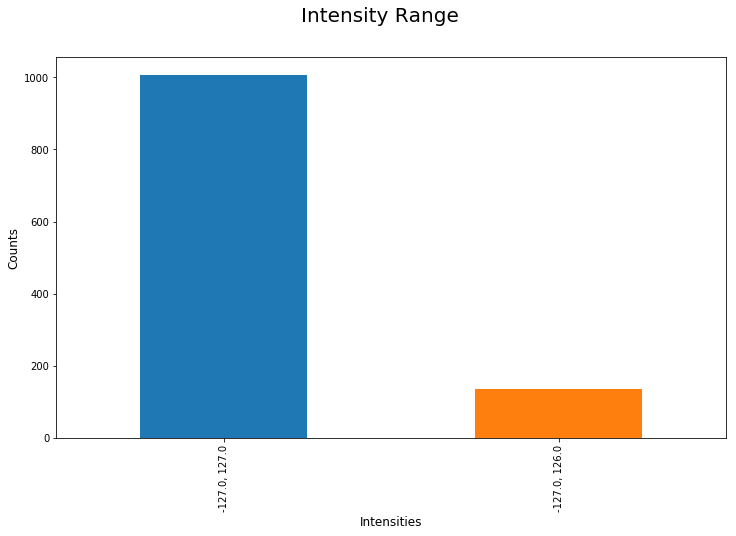

In [12]:
#Plotting Intensities Ranges After Rescaling 
#Rescasled to the appropriate range

plot_intensities(common_list)

In [17]:
#creating lists with images of different modalities

normalized_list = []
t2_list = []
t1_list = []
t1ce_list = []
flair_list = []
seg_list = []
for (dirpath, dirnames, filenames) in os.walk('/mnt/e//Image Processing/Brats Project/new/'):
    for filename in filenames: 
        if filename.endswith('.csv')==False and 'seg' not in filename.split('.')[0]:
            normalized_list.append(os.path.join(dirpath,filename))
            if 't2' in filename.split('.')[0]: 
                t2_list.append(os.path.join(dirpath,filename))
            if 't1' in filename.split('.')[0] and 't1ce' not in filename.split('.')[0]:
                t1_list.append(os.path.join(dirpath,filename))
            if 't1ce' in filename.split('.')[0]:
                t1ce_list.append(os.path.join(dirpath,filename))
            if 'flair' in filename.split('.')[0]:
                flair_list.append(os.path.join(dirpath,filename))
        if 'seg' in filename.split('.')[0]:
            seg_list.append(os.path.join(dirpath,filename))

In [18]:
#All of Modalities` paths into one dataframe for further processing

paths_data=pd.DataFrame(np.column_stack([t1_list,t1ce_list,t2_list,flair_list,seg_list]),
                       columns=['t1_p','t1ce_p','t2_p','flair_p','seg_p'])

pd.set_option('display.max_colwidth', -1)
paths_data.loc[222,:]
paths_data.to_csv('./new_paths.csv')

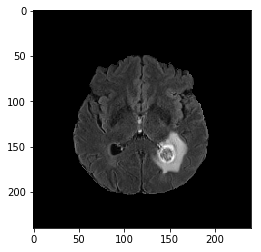

In [58]:
im = sitk.ReadImage(flair_list[30])
im_arr=sitk.GetArrayFromImage(im)

myshow(im_arr,70)

In [2]:
df=pd.read_csv('./new_paths.csv') #saving new paths with rescaled images